# EDA on Asteroid Dataset

In [1]:
%cd /content/drive/MyDrive/Colab/Asteroid
!ls

/content/drive/MyDrive/Colab/Asteroid
Asteroid.ipynb	kaggle.json


## Importing Libraries

In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
import xgboost as xgb 
from sklearn.ensemble import RandomForestClassifier

## Downloading and reading files

In [3]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Colab/Asteroid"

# Downloading Asteroid Data using kaggle API
!kaggle datasets download -d sakhawat18/asteroid-dataset
!ls
!unzip \*.zip && rm *.zip

 99% 180M/182M [00:02<00:00, 53.9MB/s]
100% 182M/182M [00:02<00:00, 72.6MB/s]
asteroid-dataset.zip  Asteroid.ipynb  kaggle.json
Archive:  asteroid-dataset.zip
  inflating: dataset.csv             


In [4]:
data = pd.read_csv('dataset.csv', dtype={'pdes':str, 'name':str, 'prefix':str})  # To get rid of DtypeWarning, adding specific data types to columns (3, 4, 5)
data = pd.DataFrame(data)

## Data Analysis

In [5]:
data.head()

,id,spkid,full_name,pdes,name,prefix,neo,pha,H,diameter,albedo,diameter_sigma,orbit_id,epoch,epoch_mjd,epoch_cal,equinox,e,a,q,i,om,w,ma,ad,n,tp,tp_cal,per,per_y,moid,moid_ld,sigma_e,sigma_a,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,class,rms
0,a0000001,2000001,1 Ceres,1,Ceres,NaN,N,N,3.40,939.400,0.0900,0.200,JPL 47,2458600.5,58600,20190427.0,J2000,0.076009,2.769165,2.558684,10.594067,80.305531,73.597695,77.372098,2.979647,0.213885,2.458239e+06,2.018043e+07,1683.145703,4.608202,1.59478,620.640533,4.819000e-12,1.032800e-11,1.956900e-11,4.608900e-09,6.168800e-08,6.624800e-08,7.820700e-09,1.111300e-11,1.196500e-12,3.782900e-08,9.415900e-09,MBA,0.43301
1,a0000002,2000002,2 Pallas,2,Pallas,NaN,N,N,4.20,545.000,0.1010,18.000,JPL 37,2459000.5,59000,20200531.0,J2000,0.229972,2.773841,2.135935,34.832932,173.024741,310.202392,144.975675,3.411748,0.213345,2.458321e+06,2.018072e+07,1687.410992,4.619880,1.23429,480.348639,3.193400e-08,4.033700e-09,8.832200e-08,3.469400e-06,6.272400e-06,9.128200e-06,8.859100e-06,4.961300e-09,4.653600e-10,4.078700e-05,3.680700e-06,MBA,0.35936
2,a0000003,2000003,3 Juno,3,Juno,NaN,N,N,5.33,246.596,0.2140,10.594,JPL 112,2459000.5,59000,20200531.0,J2000,0.256936,2.668285,1.982706,12.991043,169.851482,248.066193,125.435355,3.353865,0.226129,2.458446e+06,2.018112e+07,1592.013769,4.358696,1.03429,402.514639,3.052000e-08,3.471800e-09,8.139200e-08,3.223100e-06,1.664600e-05,1.772100e-05,8.110400e-06,4.363900e-09,4.413400e-10,3.528800e-05,3.107200e-06,MBA,0.33848
3,a0000004,2000004,4 Vesta,4,Vesta,NaN,N,N,3.00,525.400,0.4228,0.200,JPL 35,2458600.5,58600,20190427.0,J2000,0.088721,2.361418,2.151909,7.141771,103.810804,150.728541,95.861938,2.570926,0.271609,2.458248e+06,2.018051e+07,1325.432763,3.628837,1.13948,443.451432,2.332100e-10,1.514300e-09,1.928600e-09,2.170600e-07,3.880800e-07,1.789300e-07,1.206800e-06,1.648600e-09,2.612500e-10,4.103700e-06,1.274900e-06,MBA,0.39980
4,a0000005,2000005,5 Astraea,5,Astraea,NaN,N,N,6.90,106.699,0.2740,3.140,JPL 114,2459000.5,59000,20200531.0,J2000,0.190913,2.574037,2.082619,5.367427,141.571026,358.648418,17.846343,3.065455,0.238661,2.458926e+06,2.020032e+07,1508.414421,4.129814,1.09575,426.433028,2.373700e-08,3.970900e-09,6.092400e-08,2.740800e-06,2.894900e-05,2.984200e-05,8.303800e-06,4.729000e-09,5.522700e-10,3.474300e-05,3.490500e-06,MBA,0.52191


In [6]:
data.tail()

,id,spkid,full_name,pdes,name,prefix,neo,pha,H,diameter,albedo,diameter_sigma,orbit_id,epoch,epoch_mjd,epoch_cal,equinox,e,a,q,i,om,w,ma,ad,n,tp,tp_cal,per,per_y,moid,moid_ld,sigma_e,sigma_a,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,class,rms
958519,bPLS6013,3246801,(6013 P-L),6013 P-L,NaN,NaN,N,N,17.135,NaN,NaN,NaN,JPL 5,2437203.5,37203,19600926.0,J2000,0.185919,2.280861,1.856807,5.984416,194.229902,195.442802,342.057565,2.704916,0.286125,2.437266e+06,1.960113e+07,1258.191614,3.444741,0.861979,335.456367,2.142200e-02,8.779900e-01,7.299800e-01,6.969000,7.433000,46.311000,27.383000,1.041200e+00,1.652100e-01,130.970000,726.490000,MBA,0.23839
958520,bPLS6331,3246834,(6331 P-L),6331 P-L,NaN,NaN,N,N,18.500,NaN,NaN,NaN,8,2459000.5,59000,20200531.0,J2000,0.282920,2.334910,1.674319,8.082280,355.248239,5.216223,260.113042,2.995502,0.276248,2.459362e+06,2.021053e+07,1303.177916,3.567907,0.671242,261.227249,2.642000e-07,1.885500e-08,6.256300e-07,0.000016,0.000056,0.000238,0.000130,2.418900e-08,3.346100e-09,0.000469,0.000016,MBA,0.53633
958521,bPLS6344,3013075,(6344 P-L),6344 P-L,NaN,NaN,Y,Y,20.400,NaN,NaN,NaN,17,2459000.5,59000,20200531.0,J2000,0.662446,2.817152,0.950941,4.679278,182.982832,234.894852,240.473601,4.683363,0.208444,2.459574e+06,2.021123e+07,1727.085364,4.728502,0.035589,13.850093,6.636800e-08,9.925600e-08,1.687100e-07,0.000019,0.000057,0.000090,0.000053,1.650100e-07,1.101600e-08,0.000283,0.000091,APO,0.51556
958522,bT2S2060,3246457,(2060 T-2),2060 T-2,NaN,NaN,N,N,18.071,NaN,NaN,NaN,JPL 3,2441956.5,41956,19731001.0,J2000,0.202053,2.373137,1.893638,0.732484,176.499082,198.026527,355.351127,2.852636,0.269600,2.441974e+06,1.973102e+07,1335.311579,3.655884,0.893896,347.877506,3.169800e-02,5.966200e-01,5.478400e-01,0.544880,4.391600,18.988000,10.838000,7.171600e-01,1.016700e-01,38.984000,503.550000,MBA,0.25641
958523,bT3S2678,3246553,(2678 T-3),2678 T-3,NaN,NaN,N,N,18.060,NaN,NaN,NaN,JPL 3,2443429.5,43429,19771013.0,J2000,0.258348,2.260404,1.676433,9.661947,204.512448,148.496988,15.320134,2.844376,0.290018,2.443377e+06,1.977082e+07,1241.302609,3.398501,0.680220,264.721217,1.486800e-02,1.292700e-01,6.252600e-02,1.102300,0.311700,1.284300,0.473610,1.626700e-01,2.487900e-02,5.523600,106.480000,MBA,0.26980


In [7]:
data.sample(5)

,id,spkid,full_name,pdes,name,prefix,neo,pha,H,diameter,albedo,diameter_sigma,orbit_id,epoch,epoch_mjd,epoch_cal,equinox,e,a,q,i,om,w,ma,ad,n,tp,tp_cal,per,per_y,moid,moid_ld,sigma_e,sigma_a,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,class,rms
374486,a0374487,2374487,374487 (2005 YG90),374487,NaN,NaN,N,N,16.600,NaN,NaN,NaN,JPL 14,2459000.5,59000,20200531.0,J2000,0.045628,2.749286,2.623841,4.800557,277.382135,133.584673,118.833628,2.874730,0.216209,2.458451e+06,2.018113e+07,1665.053589,4.558668,1.637480,637.258092,6.516300e-08,3.117200e-08,1.885700e-07,0.000007,0.000080,0.000108,0.000072,3.259500e-08,3.677200e-09,0.000333,0.000028,MBA,0.56636
943592,bK18VB3G,3979258,(2018 VG113),2018 VG113,NaN,NaN,N,N,17.713,NaN,NaN,NaN,JPL 1,2459000.5,59000,20200531.0,J2000,0.257765,3.160317,2.345698,16.438970,66.470637,343.823321,104.176399,3.974936,0.175432,2.458407e+06,2.018102e+07,2052.080382,5.618290,1.361430,529.827713,3.322200e-05,7.288200e-04,6.224400e-04,0.009851,0.001444,0.021510,0.036091,9.166800e-04,6.068600e-05,0.068584,0.709860,MBA,0.60204
582128,bK05M00A,3279866,(2005 MA),2005 MA,NaN,NaN,Y,N,26.900,NaN,NaN,NaN,11,2459000.5,59000,20200531.0,J2000,0.580452,2.035693,0.854071,2.938690,264.967288,61.428477,38.713893,3.217316,0.339340,2.458886e+06,2.020021e+07,1060.881627,2.904536,0.005241,2.039496,5.275500e-04,2.513000e-03,1.963800e-05,0.002669,0.000231,0.004100,3.418100,3.971600e-03,6.283500e-04,9.861500,1.964400,APO,0.47736
678065,bK10L79Q,3529873,(2010 LQ79),2010 LQ79,NaN,NaN,N,N,NaN,2.395,0.077,0.297,JPL 7,2455358.5,55358,20100611.0,J2000,0.018496,2.483728,2.437788,26.967991,148.892362,18.392767,157.180402,2.529668,0.251796,2.454734e+06,2.008092e+07,1429.731410,3.914391,1.449970,564.284825,2.031100e+00,7.773700e+00,1.266900e+01,11.423000,17.617000,5715.300000,5833.600000,7.917500e+00,1.182100e+00,20456.000000,6712.300000,MBA,0.36024
424890,a0424891,2424891,424891 (2008 WQ29),424891,NaN,NaN,N,N,16.200,NaN,NaN,NaN,JPL 17,2459000.5,59000,20200531.0,J2000,0.281979,3.068096,2.202957,15.096263,261.349275,98.967120,92.203666,3.933235,0.183401,2.458498e+06,2.019011e+07,1962.916501,5.374172,1.260640,490.603269,1.011000e-07,3.969400e-08,3.237100e-07,0.000015,0.000042,0.000055,0.000030,5.088700e-08,3.559200e-09,0.000161,0.000038,MBA,0.50241


In [8]:
data.shape

(958524, 45)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958524 entries, 0 to 958523
Data columns (total 45 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              958524 non-null  object 
 1   spkid           958524 non-null  int64  
 2   full_name       958524 non-null  object 
 3   pdes            958524 non-null  object 
 4   name            22064 non-null   object 
 5   prefix          18 non-null      object 
 6   neo             958520 non-null  object 
 7   pha             938603 non-null  object 
 8   H               952261 non-null  float64
 9   diameter        136209 non-null  float64
 10  albedo          135103 non-null  float64
 11  diameter_sigma  136081 non-null  float64
 12  orbit_id        958524 non-null  object 
 13  epoch           958524 non-null  float64
 14  epoch_mjd       958524 non-null  int64  
 15  epoch_cal       958524 non-null  float64
 16  equinox         958524 non-null  object 
 17  e         

In [10]:
# Checking for null values
total = data.isnull().sum().sort_values(ascending=False)
perc = (data.isnull().sum() / data.shape[0]).sort_values(ascending=False)
nullData = pd.concat([total, perc], axis=1, keys=['Total', 'Percentage'])
nullData = nullData[nullData['Total'] > 0]
nullData

,Total,Percentage
prefix,958506,0.999981
name,936460,0.976981
albedo,823421,0.859051
diameter_sigma,822443,0.858031
diameter,822315,0.857897
sigma_per,19926,0.020788
sigma_ad,19926,0.020788
sigma_q,19922,0.020784
sigma_a,19922,0.020784
sigma_e,19922,0.020784


In [11]:
colToDrop = ['prefix', 'name', 'albedo', 'diameter_sigma', 'diameter']  # Too many null values
colToDrop.extend(['id', 'spkid', 'full_name'])  # Not useful for the data

data.drop(colToDrop, axis=1, inplace=True)
data.shape

(958524, 37)

In [12]:
data.dropna(inplace=True)  # We have an ample amount of data to work with

In [13]:
data.describe()

,H,epoch,epoch_mjd,epoch_cal,e,a,q,i,om,w,ma,ad,n,tp,tp_cal,per,per_y,moid,moid_ld,sigma_e,sigma_a,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,rms
count,932335.000000,9.323350e+05,932335.000000,9.323350e+05,932335.000000,932335.000000,932335.000000,932335.000000,932335.000000,932335.000000,932335.000000,932335.000000,9.323350e+05,9.323350e+05,9.323350e+05,9.323350e+05,9.323350e+05,9.323350e+05,932335.000000,9.323350e+05,9.323350e+05,9.323350e+05,9.323350e+05,9.323350e+05,9.323350e+05,9.323350e+05,9.323350e+05,9.323350e+05,9.323350e+05,9.323350e+05,9.323350e+05
mean,16.890009,2.458895e+06,58894.728019,2.019763e+07,0.156221,2.932576,2.398889,8.996685,168.395504,181.381528,177.029288,3.466264,2.366079e-01,2.458881e+06,2.019650e+07,5.181062e+03,1.418497e+01,1.416224e+00,551.151774,6.850723e-01,1.529656e+01,1.980729e+01,9.920530e-01,4.104756e+00,4.305258e+05,4.304413e+05,2.120456e+01,2.471471e-02,1.281599e+08,8.559499e+04,5.669526e-01
std,1.801243,6.439097e+02,643.909665,1.775660e+04,0.093001,36.458214,2.165155,6.606939,102.863983,103.910012,105.755363,72.768238,7.998658e-02,1.570733e+03,4.310784e+04,2.341160e+06,6.409747e+03,2.162511e+00,841.584584,9.366534e+01,4.407106e+03,2.913524e+03,1.284591e+02,1.337408e+03,7.330317e+07,7.329691e+07,7.221158e+03,9.820940e+00,2.194193e+10,2.776960e+07,2.783500e+00
min,-1.100000,2.425052e+06,25051.000000,1.927062e+07,0.000003,0.555418,0.070511,0.007744,0.000025,0.000130,-67.136826,0.653773,1.608247e-07,2.283183e+06,1.539011e+07,1.511918e+02,4.139405e-01,4.544120e-07,0.000177,4.819000e-12,1.032800e-11,1.956900e-11,4.608900e-09,6.168800e-08,6.624800e-08,7.820700e-09,1.111300e-11,1.196500e-12,3.782900e-08,9.415900e-09,3.292200e-11
25%,16.000000,2.459000e+06,59000.000000,2.020053e+07,0.092159,2.389088,1.972209,4.135562,80.528010,91.490632,83.559707,2.783886,1.893978e-01,2.458572e+06,2.019033e+07,1.348797e+03,3.692806e+00,9.802070e-01,381.467158,5.461100e-08,2.037600e-08,1.457800e-07,6.080850e-06,3.604400e-05,5.733400e-05,2.562600e-05,2.330950e-08,2.758900e-09,1.105900e-04,1.786300e-05,5.220800e-01
50%,16.900000,2.459000e+06,59000.000000,2.020053e+07,0.144933,2.647971,2.227213,7.357845,159.871187,182.353840,174.966411,3.048692,2.287359e-01,2.458951e+06,2.020041e+07,1.573868e+03,4.309014e+00,1.241280e+00,483.068938,8.120900e-08,3.814700e-08,2.256800e-07,8.645100e-06,6.583800e-05,1.037900e-04,4.853800e-05,4.320600e-08,4.605400e-09,2.207400e-04,3.469800e-05,5.680300e-01
75%,17.700000,2.459000e+06,59000.000000,2.020053e+07,0.200589,3.002982,2.580130,12.332702,251.974383,271.551596,269.594110,3.365569,2.669045e-01,2.459365e+06,2.021053e+07,1.900761e+03,5.203999e+00,1.593700e+00,620.220229,2.196500e-07,9.997550e-08,6.203350e-07,1.554800e-05,1.568000e-04,2.978400e-04,1.626600e-04,1.143500e-07,1.077200e-08,7.716300e-04,9.360750e-05,6.149300e-01
max,33.200000,2.459000e+06,59000.000000,2.020053e+07,0.999851,33488.895955,80.398819,175.082901,359.999793,359.999646,491.618014,66972.796064,2.381082e+00,2.546362e+06,2.259081e+07,2.238462e+09,6.128574e+06,7.947660e+01,30929.908422,3.942500e+04,3.241200e+06,1.015000e+06,5.533000e+04,1.199100e+06,3.340000e+10,3.339300e+10,5.509700e+06,7.698800e+03,1.041500e+13,1.910700e+10,2.686600e+03


### Checking relation between the attributes

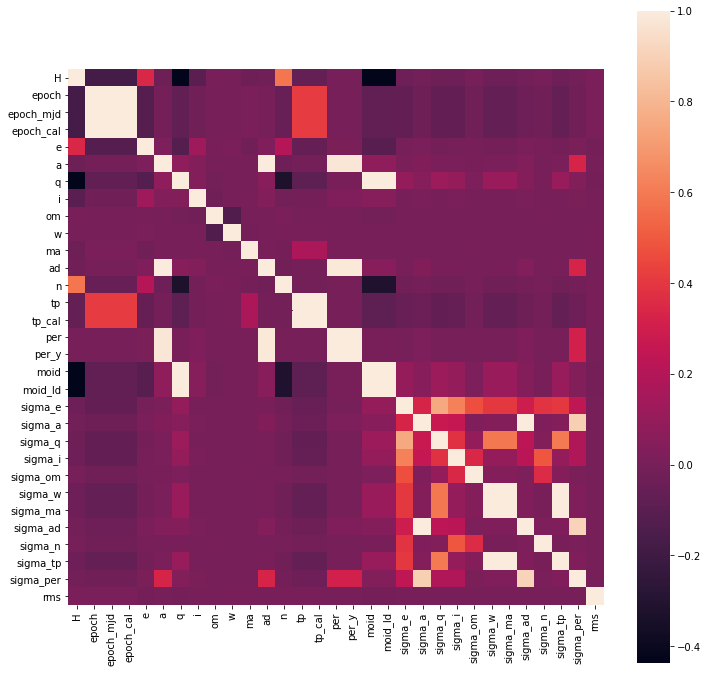

In [14]:
corrmat = data.corr()

f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corrmat, square=True)

In [15]:
corrmat.style.background_gradient(cmap='PuBu')

,H,epoch,epoch_mjd,epoch_cal,e,a,q,i,om,w,ma,ad,n,tp,tp_cal,per,per_y,moid,moid_ld,sigma_e,sigma_a,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,rms
H,1.000000,-0.175621,-0.175621,-0.176390,0.347487,-0.037235,-0.437252,-0.097795,0.001037,-0.003268,-0.034284,-0.024301,0.589160,-0.061550,-0.061943,-0.004488,-0.004488,-0.433001,-0.433001,-0.028183,-0.016110,-0.033503,-0.029511,-0.004489,-0.028657,-0.028655,-0.013448,0.000111,-0.028493,-0.013073,0.006653
epoch,-0.175621,1.000000,1.000000,0.999575,-0.113089,-0.006284,-0.073321,-0.019481,-0.002565,-0.001312,0.009869,-0.004115,-0.051564,0.415246,0.414804,-0.000500,-0.000500,-0.074989,-0.074989,-0.068711,-0.035716,-0.069032,-0.068258,-0.022492,-0.062105,-0.062101,-0.030502,-0.017597,-0.061674,-0.027051,0.008526
epoch_mjd,-0.175621,1.000000,1.000000,0.999575,-0.113089,-0.006284,-0.073321,-0.019481,-0.002565,-0.001312,0.009869,-0.004115,-0.051564,0.415246,0.414804,-0.000500,-0.000500,-0.074989,-0.074989,-0.068711,-0.035716,-0.069032,-0.068258,-0.022492,-0.062105,-0.062101,-0.030502,-0.017597,-0.061674,-0.027051,0.008526
epoch_cal,-0.176390,0.999575,0.999575,1.000000,-0.114141,-0.006443,-0.072826,-0.019181,-0.001847,-0.001388,0.010205,-0.004289,-0.051996,0.414934,0.414536,-0.000712,-0.000712,-0.074489,-0.074489,-0.068530,-0.035436,-0.068945,-0.067960,-0.022594,-0.061759,-0.061754,-0.030211,-0.017564,-0.061328,-0.026846,0.008508
e,0.347487,-0.113089,-0.113089,-0.114141,1.000000,0.022284,-0.119058,0.131239,0.003467,0.008264,-0.025797,0.025872,0.200969,-0.056849,-0.057304,0.012185,0.012185,-0.109452,-0.109452,-0.002305,0.008584,-0.006229,-0.000568,-0.000074,-0.009843,-0.009843,0.009153,0.000951,-0.009792,0.013487,-0.004963
a,-0.037235,-0.006284,-0.006284,-0.006443,0.022284,1.000000,0.083221,0.039547,-0.002115,-0.001211,0.000798,0.999560,-0.029955,-0.007868,-0.007843,0.981604,0.981604,0.083374,0.083374,0.006799,0.031683,0.007747,0.006786,0.001197,0.006639,0.006638,0.036791,0.000117,0.006617,0.329316,-0.000586
q,-0.437252,-0.073321,-0.073321,-0.072826,-0.119058,0.083221,1.000000,0.036496,-0.011159,-0.002107,-0.002306,0.053636,-0.327702,-0.088315,-0.087893,0.005498,0.005498,0.999734,0.999734,0.098613,0.050976,0.119885,0.096427,0.018635,0.113193,0.113185,0.041894,0.001431,0.112829,0.036303,-0.005522
i,-0.097795,-0.019481,-0.019481,-0.019181,0.131239,0.039547,0.036496,1.000000,-0.016641,-0.002907,0.002485,0.038541,-0.012012,-0.010190,-0.009849,0.026532,0.026532,0.045720,0.045720,-0.000334,0.008007,-0.000571,0.009325,-0.002265,-0.003608,-0.003608,0.008314,-0.001553,-0.003590,0.016874,-0.003651
om,0.001037,-0.002565,-0.002565,-0.001847,0.003467,-0.002115,-0.011159,-0.016641,1.000000,-0.138957,-0.001046,-0.001787,0.008433,-0.001474,-0.001534,-0.001443,-0.001443,-0.011177,-0.011177,-0.001112,0.000306,-0.002110,-0.001060,-0.001154,-0.001709,-0.001709,0.000448,0.000693,-0.001713,0.000517,-0.001822
w,-0.003268,-0.001312,-0.001312,-0.001388,0.008264,-0.001211,-0.002107,-0.002907,-0.138957,1.000000,-0.006840,-0.001151,0.002909,0.001180,0.001156,-0.001256,-0.001256,-0.002117,-0.002117,-0.001914,-0.000058,-0.002265,-0.002212,0.000651,-0.002823,-0.002824,0.000041,-0.001722,-0.002858,-0.000559,0.001470


In [16]:
upper = corrmat.abs().where(np.triu(np.ones(corrmat.shape), 1).astype(np.bool))
cols = [column for column in upper.columns if any(upper[column] > 0.8)]  # Most correlated attributes have a relation greater than 0.8

print(cols)
data.drop(cols, axis=1, inplace=True)

['epoch_mjd', 'epoch_cal', 'ad', 'tp_cal', 'per', 'per_y', 'moid', 'moid_ld', 'sigma_ma', 'sigma_ad', 'sigma_tp', 'sigma_per']


In [17]:
data.shape

(932335, 25)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 932335 entries, 0 to 958523
Data columns (total 25 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   pdes      932335 non-null  object 
 1   neo       932335 non-null  object 
 2   pha       932335 non-null  object 
 3   H         932335 non-null  float64
 4   orbit_id  932335 non-null  object 
 5   epoch     932335 non-null  float64
 6   equinox   932335 non-null  object 
 7   e         932335 non-null  float64
 8   a         932335 non-null  float64
 9   q         932335 non-null  float64
 10  i         932335 non-null  float64
 11  om        932335 non-null  float64
 12  w         932335 non-null  float64
 13  ma        932335 non-null  float64
 14  n         932335 non-null  float64
 15  tp        932335 non-null  float64
 16  sigma_e   932335 non-null  float64
 17  sigma_a   932335 non-null  float64
 18  sigma_q   932335 non-null  float64
 19  sigma_i   932335 non-null  float64
 20  sigm

### Handling Categorical data

In [19]:
data['pdes'].value_counts()

354098        1
261735        1
237700        1
474311        1
2013 TY114    1
             ..
174763        1
297017        1
413450        1
2019 PM8      1
2008 UN152    1
Name: pdes, Length: 932335, dtype: int64

In [20]:
data.drop(['pdes'], axis=1, inplace=True)  # Not useful for the data

In [21]:
data['neo'].value_counts()

N    909452
Y     22883
Name: neo, dtype: int64

In [22]:
data['neo'] = data['neo'].apply(lambda x:1 if x=='Y' else 0)  # Converting into binary data

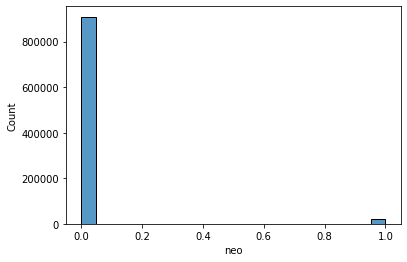

In [23]:
sns.histplot(data['neo'])

In [24]:
data['pha'].value_counts()

N    930269
Y      2066
Name: pha, dtype: int64

In [25]:
data['pha'] = data['pha'].apply(lambda x:1 if x=='Y' else 0)  # Converting into binary data

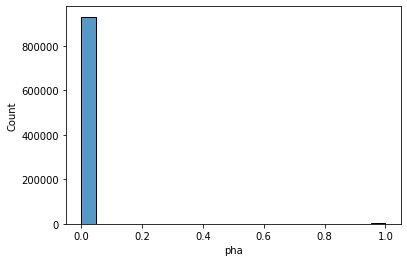

In [26]:
sns.histplot(data['pha'])

In [27]:
data['orbit_id'].value_counts()

1          50142
JPL 1      47494
JPL 2      34563
JPL 3      29905
12         29136
           ...  
JPL 447        1
JPL 350        1
200            1
176            1
442            1
Name: orbit_id, Length: 525, dtype: int64

In [28]:
data.drop(['orbit_id'], axis=1, inplace=True)  # Not useful for the data

In [29]:
data['equinox'].value_counts()

J2000    932335
Name: equinox, dtype: int64

In [30]:
data.drop(['equinox'], axis=1, inplace=True)  # Not useful for the data

In [31]:
data['class'].value_counts()

MBA    832650
OMB     27170
IMB     19702
MCA     17789
APO     12684
AMO      8448
TJN      8122
TNO      3459
ATE      1729
CEN       503
AST        57
IEO        22
Name: class, dtype: int64

In [32]:
excludeVar = data['class'].value_counts().keys()

In [33]:
classes = pd.get_dummies(data['class'])  # One hot encoding the class attribute
classes.sample(20)

,AMO,APO,AST,ATE,CEN,IEO,IMB,MBA,MCA,OMB,TJN,TNO
152342,0,0,0,0,0,0,0,1,0,0,0,0
210056,0,0,0,0,0,0,0,1,0,0,0,0
522079,0,0,0,0,0,0,0,1,0,0,0,0
69070,0,0,0,0,0,0,0,1,0,0,0,0
223084,0,0,0,0,0,0,0,1,0,0,0,0
914514,0,0,0,0,0,0,0,1,0,0,0,0
105802,0,0,0,0,0,0,0,0,0,0,1,0
463013,0,0,0,0,0,0,0,1,0,0,0,0
4275,0,0,0,0,0,0,0,0,1,0,0,0
575020,0,0,0,0,0,0,0,1,0,0,0,0


In [34]:
data = pd.concat([data.drop('class', axis=1), classes], axis=1)  # Removing class attribute itself and adding the one hot encoded attributes

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 932335 entries, 0 to 958523
Data columns (total 33 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   neo       932335 non-null  int64  
 1   pha       932335 non-null  int64  
 2   H         932335 non-null  float64
 3   epoch     932335 non-null  float64
 4   e         932335 non-null  float64
 5   a         932335 non-null  float64
 6   q         932335 non-null  float64
 7   i         932335 non-null  float64
 8   om        932335 non-null  float64
 9   w         932335 non-null  float64
 10  ma        932335 non-null  float64
 11  n         932335 non-null  float64
 12  tp        932335 non-null  float64
 13  sigma_e   932335 non-null  float64
 14  sigma_a   932335 non-null  float64
 15  sigma_q   932335 non-null  float64
 16  sigma_i   932335 non-null  float64
 17  sigma_om  932335 non-null  float64
 18  sigma_w   932335 non-null  float64
 19  sigma_n   932335 non-null  float64
 20  rms 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


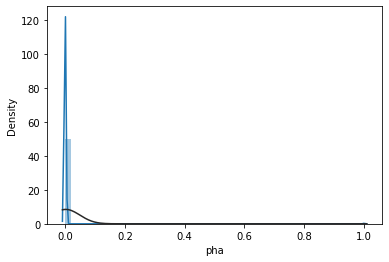

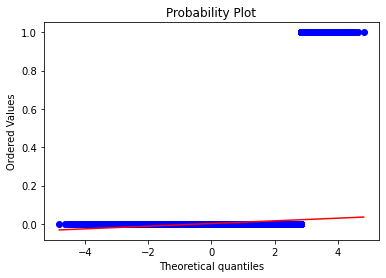

In [36]:
sns.distplot(data['pha'], fit=norm)
fig = plt.figure()
res = stats.probplot(data['pha'], plot=plt)

In [37]:
excludeVar = list(set(excludeVar))
excludeVar.extend(['neo', 'pha'])

### Scaling the data using Standard Scaling

In [38]:
scaler = StandardScaler()
scale = list(set(data.columns) - set(excludeVar))
scaler.fit(data[scale])
scaleData = scaler.transform(data[scale])
data = pd.concat([pd.DataFrame(scaleData, columns=scale), data[excludeVar]], axis=1)

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958184 entries, 0 to 958523
Data columns (total 33 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   om        932335 non-null  float64
 1   a         932335 non-null  float64
 2   sigma_i   932335 non-null  float64
 3   ma        932335 non-null  float64
 4   H         932335 non-null  float64
 5   q         932335 non-null  float64
 6   sigma_n   932335 non-null  float64
 7   sigma_a   932335 non-null  float64
 8   i         932335 non-null  float64
 9   rms       932335 non-null  float64
 10  e         932335 non-null  float64
 11  epoch     932335 non-null  float64
 12  sigma_e   932335 non-null  float64
 13  tp        932335 non-null  float64
 14  sigma_q   932335 non-null  float64
 15  sigma_w   932335 non-null  float64
 16  w         932335 non-null  float64
 17  sigma_om  932335 non-null  float64
 18  n         932335 non-null  float64
 19  IMB       932335 non-null  float64
 20  AST 

In [40]:
data.isnull().sum()

om          25849
a           25849
sigma_i     25849
ma          25849
H           25849
q           25849
sigma_n     25849
sigma_a     25849
i           25849
rms         25849
e           25849
epoch       25849
sigma_e     25849
tp          25849
sigma_q     25849
sigma_w     25849
w           25849
sigma_om    25849
n           25849
IMB         25849
AST         25849
MCA         25849
AMO         25849
TJN         25849
TNO         25849
ATE         25849
CEN         25849
APO         25849
IEO         25849
MBA         25849
OMB         25849
neo         25849
pha         25849
dtype: int64

In [41]:
data.dropna(inplace=True)

## Fitting and predicting on binary classification models

In [42]:
X = data.drop('pha', axis=1)
Y = data['pha']

In [43]:
xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size = 0.1)

In [44]:
reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.08, max_depth=4, n_estimators=500)
reg.fit(xTrain, yTrain)
yPredTrain = reg.predict(xTest)
yPredTest = reg.predict(xTest)

predictedDataFrame = pd.DataFrame({'Actual': yTest, 'Predicted': yPredTest})

In [45]:
print('Mean Absolute Error: %.2f' % mean_absolute_error(yTest, yPredTest))  
print('Mean Squared Error: %.2f' % mean_squared_error(yTest, yPredTest))  
print('Root Mean Squared Error: %.2f' % np.sqrt(mean_squared_error(yTest, yPredTest)))

Mean Absolute Error: 0.00
Mean Squared Error: 0.00
Root Mean Squared Error: 0.04


In [46]:
predictedDataFrame.sample(10)

,Actual,Predicted
690677,0.0,0.000351
419728,0.0,-0.000011
243604,0.0,-0.000015
742893,0.0,-0.000064
306795,0.0,-0.000012
163629,0.0,-0.000005
361587,0.0,0.000026
65759,0.0,0.000003
47004,0.0,-0.000020
418742,0.0,0.000053


In [47]:
rfc = RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_leaf=20, min_samples_split=10, class_weight={0:1, 1:400})
rfc.fit(xTrain, yTrain)
yPredTrain = rfc.predict(xTrain)
yPredTest = rfc.predict(xTest)

predictedDataFrame = pd.DataFrame({'Actual': yTest, 'Predicted': yPredTest})

In [48]:
print('Mean Absolute Error: %.2f' % mean_absolute_error(yTest, yPredTest))  
print('Mean Squared Error: %.2f' % mean_squared_error(yTest, yPredTest))  
print('Root Mean Squared Error: %.2f' % np.sqrt(mean_squared_error(yTest, yPredTest)))
print('Training accuracy: %.2f' % (accuracy_score(yTrain, yPredTrain) * 100), '%')
print('Testing accuracy: %.2f' % (accuracy_score(yTest, yPredTest) * 100), '%')

Mean Absolute Error: 0.01
Mean Squared Error: 0.01
Root Mean Squared Error: 0.11
Training accuracy: 98.85 %
Testing accuracy: 98.79 %


In [49]:
predictedDataFrame.sample(10)

,Actual,Predicted
724590,0.0,0.0
191884,0.0,0.0
797541,0.0,0.0
86075,0.0,0.0
129735,0.0,0.0
345168,0.0,0.0
885095,0.0,0.0
354377,0.0,0.0
484795,0.0,0.0
730041,0.0,0.0
